In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import ast
import missingno as msno
from mpl_toolkits.basemap import Basemap #For Geoplot visualizations.
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

E:\Softwares\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train_mobile = pd.read_csv('E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\data\\train_mobile_brand_after_eda.csv') #Reading the Mobile Brand data
df_train_event = pd.read_csv('E:\Shobhit\MSDS\Capstone\Y1_Capstone\data\\train_event_data_after_eda.csv') #Reading the Train Event Data
df_app_events = pd.read_csv('E:\Shobhit\MSDS\Capstone\Y1_Capstone\data\\app_events_after_eda.csv')#Reading the App Events Data
df_app_events_meta = pd.read_csv('E:\Shobhit\MSDS\Capstone\Y1_Capstone\data\\app_events_meta_data_after_eda.csv')#Reading the App Events Meta Data

In [3]:
#Checking number of rows and columns
print(df_train_mobile.shape)
print(df_train_event.shape)
print(df_app_events.shape)
print(df_app_events_meta.shape)

(74522, 6)
(1265823, 10)
(32473067, 4)
(451572, 3)


### Creating New Features

Feature engineering would be performed based on the 2 Scenarios that we have as part of problem Statement<br>
<ol>
    <li><b>Scenario 1</b>:All data is present i.e mobile brand , event data and spatial data. In this case we would be performing feature engineering on train_event_data.</li>
    <li><b>Scenario 2</b>:Only mobile brand data available.In this case less scope of feature engineering is there.</li>
</ol>

In [4]:
#Keeping train_event_data for Scenario 1
#Data Points where event data is missing is not required in the train_event_data as it adds no meaning.
#Removing datapoints where event data is missing(represented by event_id = 0).
df_train_event_s1 = df_train_event[df_train_event['event_id'] != 0]
df_train_event_s1.shape

(1214584, 10)

In [5]:
#Keeping train_event_data for Scenario 2
df_train_event_s2 = df_train_event[df_train_event['event_id'] == 0]
df_train_event_s2.shape

(51239, 10)

In [6]:
df_train_event_s2['device_id'].nunique()

51239

In [7]:
#Coverting hour to int
df_train_event_s1['Hour'] = df_train_event_s1['Hour'].astype(int) 
#Converting datetimestamp column to datetime
df_train_event_s1['datetimestamp'] = pd.to_datetime(df_train_event_s1['datetimestamp'],format = '%Y/%m/%d %H:%M:%S',exact=False)

## Feature Engineering

### Merging Data

- For Scenario 2 data we would be only having only mobile phone related data like phone_brand and device_model

In [8]:
#Joining train_mobile with train_event data for Scenario 2
df_train_event_s2 = df_train_mobile.merge(df_train_event_s2,on = 'device_id',how = 'inner')
df_train_event_s2.shape

(51239, 15)

In [9]:
#Removing duplicate columns after join
df_train_event_s2.drop('gender_x',axis=1,inplace=True)
df_train_event_s2.drop('age_x',axis=1,inplace=True)
df_train_event_s2.drop('group_train_x',axis=1,inplace=True)
df_train_event_s2.head()

,device_id,phone_brand,device_model,gender_y,age_y,group_train_y,event_id,datetimestamp,latitude,longitude,Day,Hour
0,398514470209561000,Huawei,è£è€€ç•…çŽ©4X,M,68,M32+,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
1,-3073918292047050000,Huawei,è£è€€ç•…çŽ©4C,M,27,M25-32,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
2,5805880616488060000,lshi,è¶…çº§æ‰‹æœº1,M,39,M32+,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
3,-2403560729305410000,nibilu,ç«æ˜Ÿä¸€å·,M,25,M25-32,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
4,-1889893391998300000,Huawei,è£è€€3Xç•…çŽ©ç‰ˆ,M,22,M0-24,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available


In [10]:
#Renaming the columns as per the original names
df_train_event_s2.rename(columns = {'gender_y':'gender','age_y':'age','group_train_y':'group_train'}, inplace = True)
df_train_event_s2.head()

,device_id,phone_brand,device_model,gender,age,group_train,event_id,datetimestamp,latitude,longitude,Day,Hour
0,398514470209561000,Huawei,è£è€€ç•…çŽ©4X,M,68,M32+,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
1,-3073918292047050000,Huawei,è£è€€ç•…çŽ©4C,M,27,M25-32,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
2,5805880616488060000,lshi,è¶…çº§æ‰‹æœº1,M,39,M32+,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
3,-2403560729305410000,nibilu,ç«æ˜Ÿä¸€å·,M,25,M25-32,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available
4,-1889893391998300000,Huawei,è£è€€3Xç•…çŽ©ç‰ˆ,M,22,M0-24,0,1970-01-01 00:00:00,0.0,0.0,Data Not Available,Data Not Available


In [11]:
#Removing columns from df_train_event_s2 which are not required
df_train_event_s2.drop(columns = ['group_train','datetimestamp','latitude','longitude','Day','Hour','event_id'],inplace=True)
print(df_train_event_s2.shape)
df_train_event_s2.head()

(51239, 5)


,device_id,phone_brand,device_model,gender,age
0,398514470209561000,Huawei,è£è€€ç•…çŽ©4X,M,68
1,-3073918292047050000,Huawei,è£è€€ç•…çŽ©4C,M,27
2,5805880616488060000,lshi,è¶…çº§æ‰‹æœº1,M,39
3,-2403560729305410000,nibilu,ç«æ˜Ÿä¸€å·,M,25
4,-1889893391998300000,Huawei,è£è€€3Xç•…çŽ©ç‰ˆ,M,22


In [12]:
#Joining train_mobile with train_event data
df_train_event_s1 = df_train_mobile.merge(df_train_event_s1,on = 'device_id',how = 'inner')
print(df_train_event_s1.shape)
df_train_event_s1.head()

(1214605, 15)


,device_id,gender_x,age_x,group_train_x,phone_brand,device_model,gender_y,age_y,group_train_y,event_id,datetimestamp,latitude,longitude,Day,Hour
0,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,Tuesday,15
1,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,Tuesday,6
2,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,Wednesday,3
3,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,Wednesday,2
4,-7548291590301750000,M,33,M32+,Huawei,è£è€€3C,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,Tuesday,15


In [13]:
#Removing duplicate columns after join
df_train_event_s1.drop('gender_x',axis=1,inplace=True)
df_train_event_s1.drop('age_x',axis=1,inplace=True)
df_train_event_s1.drop('group_train_x',axis=1,inplace=True)
df_train_event_s1.head()

,device_id,phone_brand,device_model,gender_y,age_y,group_train_y,event_id,datetimestamp,latitude,longitude,Day,Hour
0,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,Tuesday,15
1,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,Tuesday,6
2,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,Wednesday,3
3,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,Wednesday,2
4,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,Tuesday,15


In [14]:
#Renaming the columns as per the original names
df_train_event_s1.rename(columns = {'gender_y':'gender','age_y':'age','group_train_y':'group_train'}, inplace = True)
df_train_event_s1.head()

,device_id,phone_brand,device_model,gender,age,group_train,event_id,datetimestamp,latitude,longitude,Day,Hour
0,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,2369465,2016-05-03 15:55:35,33.98,116.79,Tuesday,15
1,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1080869,2016-05-03 06:07:16,33.98,116.79,Tuesday,6
2,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1079338,2016-05-04 03:28:02,33.98,116.79,Wednesday,3
3,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1078881,2016-05-04 02:53:08,33.98,116.79,Wednesday,2
4,-7548291590301750000,Huawei,è£è€€3C,M,33,M32+,1068711,2016-05-03 15:59:35,33.98,116.79,Tuesday,15


In [15]:
#Column group_train is not required
df_train_event_s1.drop('group_train',axis=1,inplace=True)
df_train_event_s1.head()

,device_id,phone_brand,device_model,gender,age,event_id,datetimestamp,latitude,longitude,Day,Hour
0,-7548291590301750000,Huawei,è£è€€3C,M,33,2369465,2016-05-03 15:55:35,33.98,116.79,Tuesday,15
1,-7548291590301750000,Huawei,è£è€€3C,M,33,1080869,2016-05-03 06:07:16,33.98,116.79,Tuesday,6
2,-7548291590301750000,Huawei,è£è€€3C,M,33,1079338,2016-05-04 03:28:02,33.98,116.79,Wednesday,3
3,-7548291590301750000,Huawei,è£è€€3C,M,33,1078881,2016-05-04 02:53:08,33.98,116.79,Wednesday,2
4,-7548291590301750000,Huawei,è£è€€3C,M,33,1068711,2016-05-03 15:59:35,33.98,116.79,Tuesday,15


In [16]:
#Removing rows from app_events where app was not installed and not active.
#We are removing above rows because if the app was not installed then we are not sure from where the event_id got generated from.
#If the app was not active then it might have happened that another app was active at the same time leading to an event being generated.
print(f'Data Frame Shape before filtering:{df_app_events.shape}')
df_app_events = df_app_events[list(map(lambda x:True if x else False,list((df_app_events['is_installed']) & (df_app_events['is_active']))))]
print(f'Data Frame Shape after filtering:{df_app_events.shape}')

Data Frame Shape before filtering:(32473067, 4)
Data Frame Shape after filtering:(12732996, 4)


### Grouping Multiple App Categories Under One Main Category

In [17]:
df_app_events_meta['category'].unique()

array(['Finance', 'unknown', 'DS_P2P net loan', 'Securities',
       'Lottery ticket', 'IMF', 'Precious Metals', 'pursue',
       'Science and Technology', 'Customization', 'service',
       'Smart Shopping', 'Personal Effectiveness', 'free', 'vitality',
       'Trendy / cool', 'Relatives', 'comfortable', 'Simple',
       'Debit and credit', 'Crowdfunding financing', 'Custom label',
       'Ping', 'safety Insurance', 'Peace - Search', 'mobile bank',
       'Direct Bank', 'futures', 'Property Industry 1.0', 'Industry tag',
       'Pay', 'Wealth Management', 'Customized 1', '1 free', 'Cozy 1',
       'Services 1', 'Pursuit 1', 'Noble 1', 'Trendy / cool 1',
       'Passion 1', 'Personal Effectiveness 1', 'Total Cost 1',
       'Smart Shopping 1', 'Science and Technology 1', 'Relatives 1',
       '1 vitality', 'Irritation / Fun 1', 'Quality 1', '1 reputation',
       'Nature 1', 'Simple 1', 'Classical 1', 'Property Industry 2.0',
       'Occupational identity', 'College Students',
       '

In [18]:
#All the unique app categories in app_events_meta data were grouped under main category
categories_grouped = {'Finance': ['Finance',
  'DS_P2P net loan',
  'Securities',
  'IMF',
  'Precious Metals',
  'Debit and credit',
  'Crowdfunding financing',
  'Ping',
  'safety Insurance',
  'mobile bank',
  'Direct Bank',
  'futures',
  'Pay',
  'Wealth Management',
  'Bank financing',
  'Internet banking',
  'stock',
  'Insurance',
  'other',
  'fund',
  'Stock Futures',
  'Trust',
  'Consumer loans',
  'Financial Services',
  'fixed income',
  'P2P',
  'Direct Banking',
  'Crowdfunding',
  'A shares',
  'Life Insurance',
  'Financial Supermarket',
  'exchange rate',
  'Financial Information',
  'Commodity Futures',
  'Monetary Fund',
  'Bond Fund',
  'Real Estate Trust',
  'Third party payment',
  'Other shares',
  'H shares',
  'Financial Futures',
  'Equity Fund',
  'Trust funds',
  'N shares',
  'And the Church',
  'Direct Insurance',
  'Exchange',
  ['online shopping navigation',
   'Buy',
   'coupon',
   'Sellers',
   'Traditional securities brokerage',
   'P2P net loan',
   'Third-party card management',
   'Internet Banking',
   'Consumer Finance',
   'Traditional Insurance',
   'Heritage Foundation',
   'Internet Securities',
   'Bank Credit Card',
   'Internet Insurance',
   'App Store']],
 'Science and Technology': ['Science and Technology',
  'Science and Technology 1'],
 'Shopping': ['Smart Shopping',
  'Smart Shopping 1',
  ['online malls',
   'Sea Amoy',
   'takeaway ordering',
   'Reviews',
   'Recipes',
   'fashion outfit']],
 'Property Industry': ['Property Industry 1.0',
  'Property Industry 2.0',
  ['Property Industry new']],
 'Gaming': ['Casual puzzle categories',
  'ARPG',
  'MMO',
  'Cards RPG',
  'The elimination of class',
  'read',
  'MOBA',
  'Pirated content',
  'SLG (strategy)',
  'Chess categories',
  'Tower Defense',
  ['Flight Shooting',
   'Racing (RAC)',
   'Parkour avoid class',
   'round',
   'Shootout Shooting (STG)',
   'Business simulation',
   'music',
   'Sports',
   'game',
   'game-Puzzle',
   'game-Adventure puzzle',
   'game-Parkour',
   'game-Racing',
   'game-Motorcycle',
   'game-Rowing',
   'game-aircraft',
   'game-Box',
   'game-gem',
   'game-Lianliankan',
   'game-Zuma',
   'game-Bobble',
   'game-Cartoon',
   'game-Role -playing games',
   'game-Competitive action',
   'game-Tactics',
   'game-card',
   'game-Business simulation',
   'game-Horizontal version',
   'game-shooting',
   'game-3D',
   'game-flight',
   'game-tank',
   'game-Snipe',
   'poker game_doudizhu',
   'chess',
   'majiang',
   'table game',
   'Texas Poker',
   'poker',
   'Puzzle',
   'Literacy Games',
   'Intellectual development game',
   'math',
   'checkpoints game',
   'Beach landing game'],
  ['old style game',
   'Turn based RPG game',
   'realtime fighting',
   'war chess',
   'business',
   'farm',
   'pet raising up',
   'love raising up',
   'puzzel',
   'gambling',
   '3 kindom game',
   'knight game',
   'Cultivation fantasy game',
   'Journey to the West game',
   'Outlaws of the Marsh game',
   'Chinese Classical Mythology',
   'Western Mythology',
   'zombies game',
   'World of Warcraft',
   'magic',
   'dotal-lol',
   'sailing game'],
  ['game-stress reliever',
   'game-Answer',
   'game-Fishing',
   'game-Cutting things',
   'game-Music and Dance',
   'raising up game',
   'Guard tower defense game',
   'game-Leisure time',
   'Card Game',
   'strategy game',
   'cosplay',
   'casual games',
   'Games',
   'Puzzles',
   'Sports Games',
   'action games',
   'Educational games',
   'Chess game',
   'Music Games',
   'Adventure Game',
   'Simulators',
   'Racing games',
   'Table Games',
   'Family Games',
   'Dice Game',
   'Word games']],
 'Maternal and child': ['Doctors',
  'Pregnant baby',
  'Prepare baby',
  'Maternal and child population',
  'Parenting stage',
  'Families with big baby',
  'Families with small babies',
  'Families with babies',
  ['Maternal and child supplies', 'Prepare pregnant pregnancy', 'Rentals']],
 'Travel': ['Low Cost Airlines',
  'High-end business aviation',
  'Full Service Airlines',
  'General Aviation',
  'Regional Aviation',
  'Airline type',
  'aviation',
  'Air Travel',
  'Airline Alliances',
  'Aeronautical Information Service',
  'airport',
  'Aviation Integrated Services',
  'Southeast Asia (aviation)',
  'Japan and South Korea (Air)',
  'Chinese mainland (Airlines)',
  'Flight area',
  'Travel Travel',
  'Overseas travel',
  'Domestic travel',
  'Tour around',
  'Integrated tourism',
  'Purpose of travel',
  'travel',
  'Free exercise',
  'Travel Information',
  'Share Tour',
  'Travel preferences',
  'Southeast Asia (Travel)',
  ['map',
   'Behalf of the drive',
   'Taxi',
   'Car',
   'flight',
   'Bus',
   'train',
   'Hotel application',
   'tourism product',
   'coach transport']],
 'Sports': ['basketball', 'football', 'tennis', 'billards', 'other ball game'],
 'Comics and animation': ['80s Japanese comic',
  '90s Japanese comic',
  'japanese and korean style',
  'japanese comic and animation',
  'US and Europe animation',
  'Cute style comic',
  'pixel style comic',
  'violence comic',
  'US and Europe magic comic',
  'realistic style comic',
  'chinese comic'],
 'Education': ['education for babies',
  'education outside class',
  'foreign language',
  'professional skills',
  'art and culture',
  'exams',
  'class managemetn',
  ['Engineering Drawing',
   'Academic Information',
   'psychology',
   'Information',
   'library',
   'Parenting',
   'study abroad',
   'blogs']],
 'Media': ['science',
  'news',
  'Entertainment News',
  'Sports News',
  'Technology Information',
  'gaming strategy',
  'weibo',
  'love and marriage',
  'community',
  'picture sharing',
  'radio',
  'video',
  'show',
  'joke',
  'Audiobooks'],
 'Home and furniture': ['Decoration',
  'Appliances',
  'Furniture',
  'household products',
  'Smart Home',
  'Smart Appliances'],
 'Health and fitness': ['lose weight',
  'sports and gym',
  'health',
  'Medical',
  'Health Management',
  'Wearable Health']}

In [19]:
categories_grouped_values = list(categories_grouped.values())
def group_app_categories(category):
    for main_category, vals in categories_grouped.items():
        if category in vals:
            return main_category
    
    return 'Other'
    
df_app_events_meta['Main_Category'] = df_app_events_meta['category'].apply(lambda val:group_app_categories(val))

In [20]:
df_app_events_meta['Main_Category'].value_counts()

Other                     341359
Property Industry          47940
Gaming                     35498
Finance                    18394
Comics and animation        2565
Travel                      1445
Media                       1214
Maternal and child           779
Education                    685
Shopping                     609
Science and Technology       597
Health and fitness           358
Sports                        99
Home and furniture            30
Name: Main_Category, dtype: int64

In [21]:
#As we already have Main_category column category,label_id column is not required now
df_app_events_meta.drop(columns = ['label_id','category'],axis=1,inplace=True)
df_app_events_meta.head()

,app_id,Main_Category
0,7.324885e+18,Finance
1,-4.494217e+18,Finance
2,6.058196e+18,Other
3,6.058196e+18,Finance
4,8.694626e+18,Other


In [22]:
#Joining train_mobile,train_event data with app_event data
df_train_event_s1 = df_train_event_s1.merge(df_app_events,on = 'event_id',how = 'inner')
print(df_train_event_s1.shape)
df_train_event_s1.head()

(4787984, 14)


,device_id,phone_brand,device_model,gender,age,event_id,datetimestamp,latitude,longitude,Day,Hour,app_id,is_installed,is_active
0,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,3.433290e+18,1,1
1,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,-5.472633e+18,1,1
2,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,8.693964e+18,1,1
3,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,5.099454e+18,1,1
4,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,-4.532037e+18,1,1


In [23]:
df_train_event_s1['device_id'].nunique()

23221

In [24]:
#Joining train_mobile,train_event data,app_event data with app_events_meta data
df_train_event_s1 = df_train_event_s1.merge(df_app_events_meta,on = 'app_id',how = 'inner')
print(df_train_event_s1.shape)
df_train_event_s1.head()

(40507870, 15)


,device_id,phone_brand,device_model,gender,age,event_id,datetimestamp,latitude,longitude,Day,Hour,app_id,is_installed,is_active,Main_Category
0,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,3.433290e+18,1,1,Other
1,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,3.433290e+18,1,1,Property Industry
2,7442042493953950000,Huawei,hu1 plus,M,26,2591882,2016-05-01 18:17:43,39.43,116.98,Sunday,18,3.433290e+18,1,1,Other
3,7442042493953950000,Huawei,hu1 plus,M,26,2591882,2016-05-01 18:17:43,39.43,116.98,Sunday,18,3.433290e+18,1,1,Property Industry
4,-800490591774117000,Huawei,hu1 Plus,F,33,1455673,2016-05-01 16:45:07,0.00,0.00,Sunday,16,3.433290e+18,1,1,Other


#### Segregating Gender and Age for Unique Device_Ids

In [25]:
df_train_event_s1_final = df_train_event_s1[['device_id','gender','age','phone_brand','device_model']]
df_train_event_s1_final.drop_duplicates(inplace = True)
print(df_train_event_s1_final.shape)
df_train_event_s1_final.head()

(23182, 5)


,device_id,gender,age,phone_brand,device_model
0,-7548291590301750000,M,33,Huawei,è£è€€3C
2,7442042493953950000,M,26,Huawei,hu1 plus
4,-800490591774117000,F,33,Huawei,hu1 Plus
6,-7430262216439700000,M,42,Huawei,Mate 7
18,5263633571423510000,M,27,Huawei,hu1 Plus


### Feature Engineering: Median Latitude and Longitude for a Device Id

In [26]:
#Applying the median lat and long  data to the data frame
df_spatial_data = df_train_event_s1[['device_id','gender','age','latitude','longitude']]
df_spatial_data.drop_duplicates(inplace = True)
print(df_spatial_data.shape)
unique_device_ids = df_spatial_data['device_id'].unique()
median_lat_long = {}
for deviceId in unique_device_ids:
    df_temp = df_spatial_data[df_spatial_data['device_id'] == deviceId]
    median_lat_long[deviceId] = [df_temp['latitude'].median(),df_temp['longitude'].median()]

# Applying the median lat and long  data to the data frame    
df_train_event_s1_final['Median_Latitude'] = df_train_event_s1_final['device_id'].apply(lambda x : median_lat_long.get(x)[0])
df_train_event_s1_final['Median_Longitude'] = df_train_event_s1_final['device_id'].apply(lambda x : median_lat_long.get(x)[1])

print(df_train_event_s1_final.shape)
df_train_event_s1_final.head()

(51094, 5)
(23182, 7)


,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79
2,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98
4,-800490591774117000,F,33,Huawei,hu1 Plus,0.00,0.00
6,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33
18,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42


### Feature Engineering: Number of Events for a Device

In [27]:
#Number of events for a device
events_per_device_dict = df_train_event_s1.groupby(['device_id','event_id']).size().to_dict()
no_events_per_device_dict = {}
for key in events_per_device_dict.keys():
    if key[0] in no_events_per_device_dict:
        no_events_per_device_dict[key[0]] += 1
    else:
        no_events_per_device_dict[key[0]] = 1
    
df_train_event_s1_final['Number_of_Events'] = df_train_event_s1_final['device_id'].apply(lambda x:no_events_per_device_dict.get(x,0))
print(df_train_event_s1_final.shape)
df_train_event_s1_final.head()

(23182, 8)


,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1
2,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1
4,-800490591774117000,F,33,Huawei,hu1 Plus,0.00,0.00,1
6,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6
18,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17


### Feature Generation : Difference in Latitude and Longitude for Morning vs Evening and Morning vs Night Time Periods

- As we observed that the data mainly lies in the China region and as per the general norm the Chinese people usually work between 08:00 and 18:00 each day, with a lunch break from 12:00 to 14:00.

In [28]:
#Segregating the columns required and removing the duplicates in order to speed up performance
df_train_event_s1_spatial_data = df_train_event_s1[['device_id','latitude','longitude','datetimestamp','Hour']]
df_train_event_s1_spatial_data.drop_duplicates(inplace = True)
df_train_event_s1_spatial_data.shape

(547563, 5)

In [29]:
#Creating categories for Hour Column
def map_hour_time(hour):
    if 0 <= hour <= 6:
        return 'Late Night'
    elif 7 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 16:
        return 'Afternoon'
    elif 17 <= hour <= 20:
        return 'Evening'
    elif 21 <= hour <=23:
        return 'Night'
df_train_event_s1_spatial_data['Time_of_Day'] = df_train_event_s1_spatial_data['Hour'].apply(lambda x : map_hour_time(x))
df_train_event_s1_spatial_data.head()

,device_id,latitude,longitude,datetimestamp,Hour,Time_of_Day
0,-7548291590301750000,33.98,116.79,2016-05-01 10:08:16,10,Morning
2,7442042493953950000,39.43,116.98,2016-05-01 18:17:43,18,Evening
4,-800490591774117000,0.00,0.00,2016-05-01 16:45:07,16,Afternoon
6,-7430262216439700000,22.51,113.92,2016-05-07 12:00:09,12,Afternoon
8,-7430262216439700000,22.51,113.92,2016-05-02 23:33:34,23,Night


In [30]:
#Getting date from datetimestamp column
df_train_event_s1_spatial_data['Event_Date'] = df_train_event_s1_spatial_data['datetimestamp'].apply(lambda x : x.date())
df_train_event_s1_spatial_data.head()

,device_id,latitude,longitude,datetimestamp,Hour,Time_of_Day,Event_Date
0,-7548291590301750000,33.98,116.79,2016-05-01 10:08:16,10,Morning,2016-05-01
2,7442042493953950000,39.43,116.98,2016-05-01 18:17:43,18,Evening,2016-05-01
4,-800490591774117000,0.00,0.00,2016-05-01 16:45:07,16,Afternoon,2016-05-01
6,-7430262216439700000,22.51,113.92,2016-05-07 12:00:09,12,Afternoon,2016-05-07
8,-7430262216439700000,22.51,113.92,2016-05-02 23:33:34,23,Night,2016-05-02


In [31]:
'''
Creating a feature to indicate when an event was triggered.
If for a given device on the same day a event was generated during morning and evening.We can calculated the difference
betweent the lat and long to get an idea where the event was generated.If there is not much difference in lat and long
then it might suggest for a person where he would use the app.
'''
unique_device_ids = df_train_event_s1_spatial_data['device_id'].unique()
deviceId_lat_long_diff_m_e = {} #For latitude and longitude difference between morning and evening for a device id
deviceId_lat_long_diff_m_n = {} #For latitude and longitude difference between morning and evening for a device id
for deviceId in unique_device_ids:
    m_e_lat_diff = 0
    m_e_long_diff = 0
    m_n_lat_diff = 0
    m_n_long_diff = 0
    df_temp = df_train_event_s1_spatial_data[df_train_event_s1_spatial_data['device_id'] == deviceId]
    df_temp = df_temp.groupby('Time_of_Day').mean(['latitutde','longitude'])
    if 'Morning' in df_temp.index:
        m_lat = df_temp.loc['Morning',:]['latitude']
        m_long = df_temp.loc['Morning',:]['longitude']
    else:
        m_lat = None
        m_long = None
    
    if 'Evening' in df_temp.index:
        e_lat = df_temp.loc['Evening',:]['latitude']
        e_long = df_temp.loc['Evening',:]['longitude']
    else:
        e_lat = None
        e_long = None
    
    if 'Night' in df_temp.index:
        n_lat = df_temp.loc['Night',:]['latitude']
        n_long = df_temp.loc['Night',:]['longitude']
    else:
        n_lat = None
        n_long = None
    
    if m_lat and e_lat:
        m_e_lat_diff = m_lat - e_lat
        m_e_long_diff = m_long - e_long
    
    if n_lat and m_lat:
        m_n_lat_diff = m_lat - n_lat
        m_n_long_diff = m_long - n_long
    
    deviceId_lat_long_diff_m_e[deviceId] = [m_e_lat_diff,m_e_long_diff]
    deviceId_lat_long_diff_m_n[deviceId] = [m_n_lat_diff,m_n_long_diff]



In [32]:
#Applying the above diff in lat and long to the data frame
df_train_event_s1_final['Latitude_Diff_Morning_Evening'] = df_train_event_s1_final['device_id'].apply(lambda x : deviceId_lat_long_diff_m_e.get(x)[0])
df_train_event_s1_final['Longitude_Diff_Morning_Evening'] = df_train_event_s1_final['device_id'].apply(lambda x : deviceId_lat_long_diff_m_e.get(x)[1])
df_train_event_s1_final['Latitude_Diff_Morning_Night'] = df_train_event_s1_final['device_id'].apply(lambda x : deviceId_lat_long_diff_m_n.get(x)[0])
df_train_event_s1_final['Longitude_Diff_Morning_Night'] = df_train_event_s1_final['device_id'].apply(lambda x : deviceId_lat_long_diff_m_n.get(x)[1])
print(df_train_event_s1_final.shape)
df_train_event_s1_final.head()

(23182, 12)


,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,0.0,0.0
2,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,0.0,0.0
4,-800490591774117000,F,33,Huawei,hu1 Plus,0.00,0.00,1,0.0,0.0,0.0,0.0
6,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,0.0,0.0
18,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,0.0,0.0


### Feature Engineering :Creating Clustering Labels for Latitude and Longitude Using DBSCAN Algorithm

In [33]:
df_train_event_s1_final.shape

(23182, 12)

In [34]:
#Removing those rows where latitude and longitude are 0.
#As indicated in problem statement that wherever the latitude and longitude is 0 it indicates the location data sharing was not
#provided or location sharing was off.Would be providing it a label at last
df_train_event_s1_spatial_data = df_train_event_s1_final[~((df_train_event_s1_final['Median_Latitude'] == 0) & (df_train_event_s1_final['Median_Longitude'] == 0))]
print(df_train_event_s1_spatial_data.shape)
df_train_event_s1_spatial_data.head()

(11571, 12)


,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,0.0,0.0
2,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,0.0,0.0
6,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,0.0,0.0
18,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,0.0,0.0
96,1604657008397660000,F,76,Huawei,è£è€€3C,20.91,61.68,7,0.0,0.0,0.0,0.0


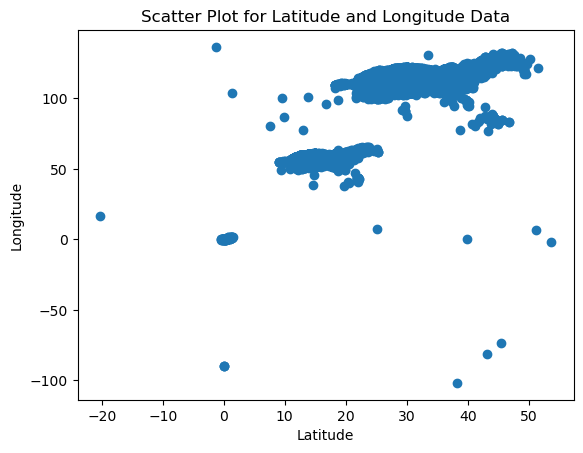

In [35]:
plt.scatter(df_train_event_s1_spatial_data['Median_Latitude'], df_train_event_s1_spatial_data['Median_Longitude'])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter Plot for Latitude and Longitude Data')
plt.show()

- There is a lot of latitude and longitude points close to one another for data points having latitude(20-50) and longitude(around 100).
- There are some other small clusters as well which our DBSCAN algorithm should be able to identify.

- There are two hyperparameters in DBSCAN algorithm that are:
    - `eps(epsilon)`:This indicates a threshold distance that would be use to consider if two points are neighbors or not.
    - `min_samples`:The minimum number of neighbors a given point should have in order to be classified as a core point.

In order to find the optimal value of `eps(epsilon)` we would make use of NearestNeighbor algorithm.
- For each point distance to the nearest n points will be calculated and then sorted.
- These distances will be plotted and the epsilon value would be selected where the change is most pronounced.

For `min_samples` the value be 4 as it is generally calculated by 2 * number of dimensions(2 here).

In [36]:
#Applying K Nearest neighbours
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(df_train_event_s1_spatial_data[['Median_Latitude','Median_Longitude']])
distances, indices = nbrs.kneighbors(df_train_event_s1_spatial_data[['Median_Latitude','Median_Longitude']])

In [37]:
distances

array([[0.        , 0.02      , 0.02236068, 0.02236068],
       [0.        , 0.06324555, 0.08602325, 0.08602325],
       [0.        , 0.        , 0.04123106, 0.06324555],
       ...,
       [0.        , 0.005     , 0.005     , 0.015     ],
       [0.        , 0.005     , 0.00707107, 0.01414214],
       [0.        , 0.02      , 0.02236068, 0.09899495]])

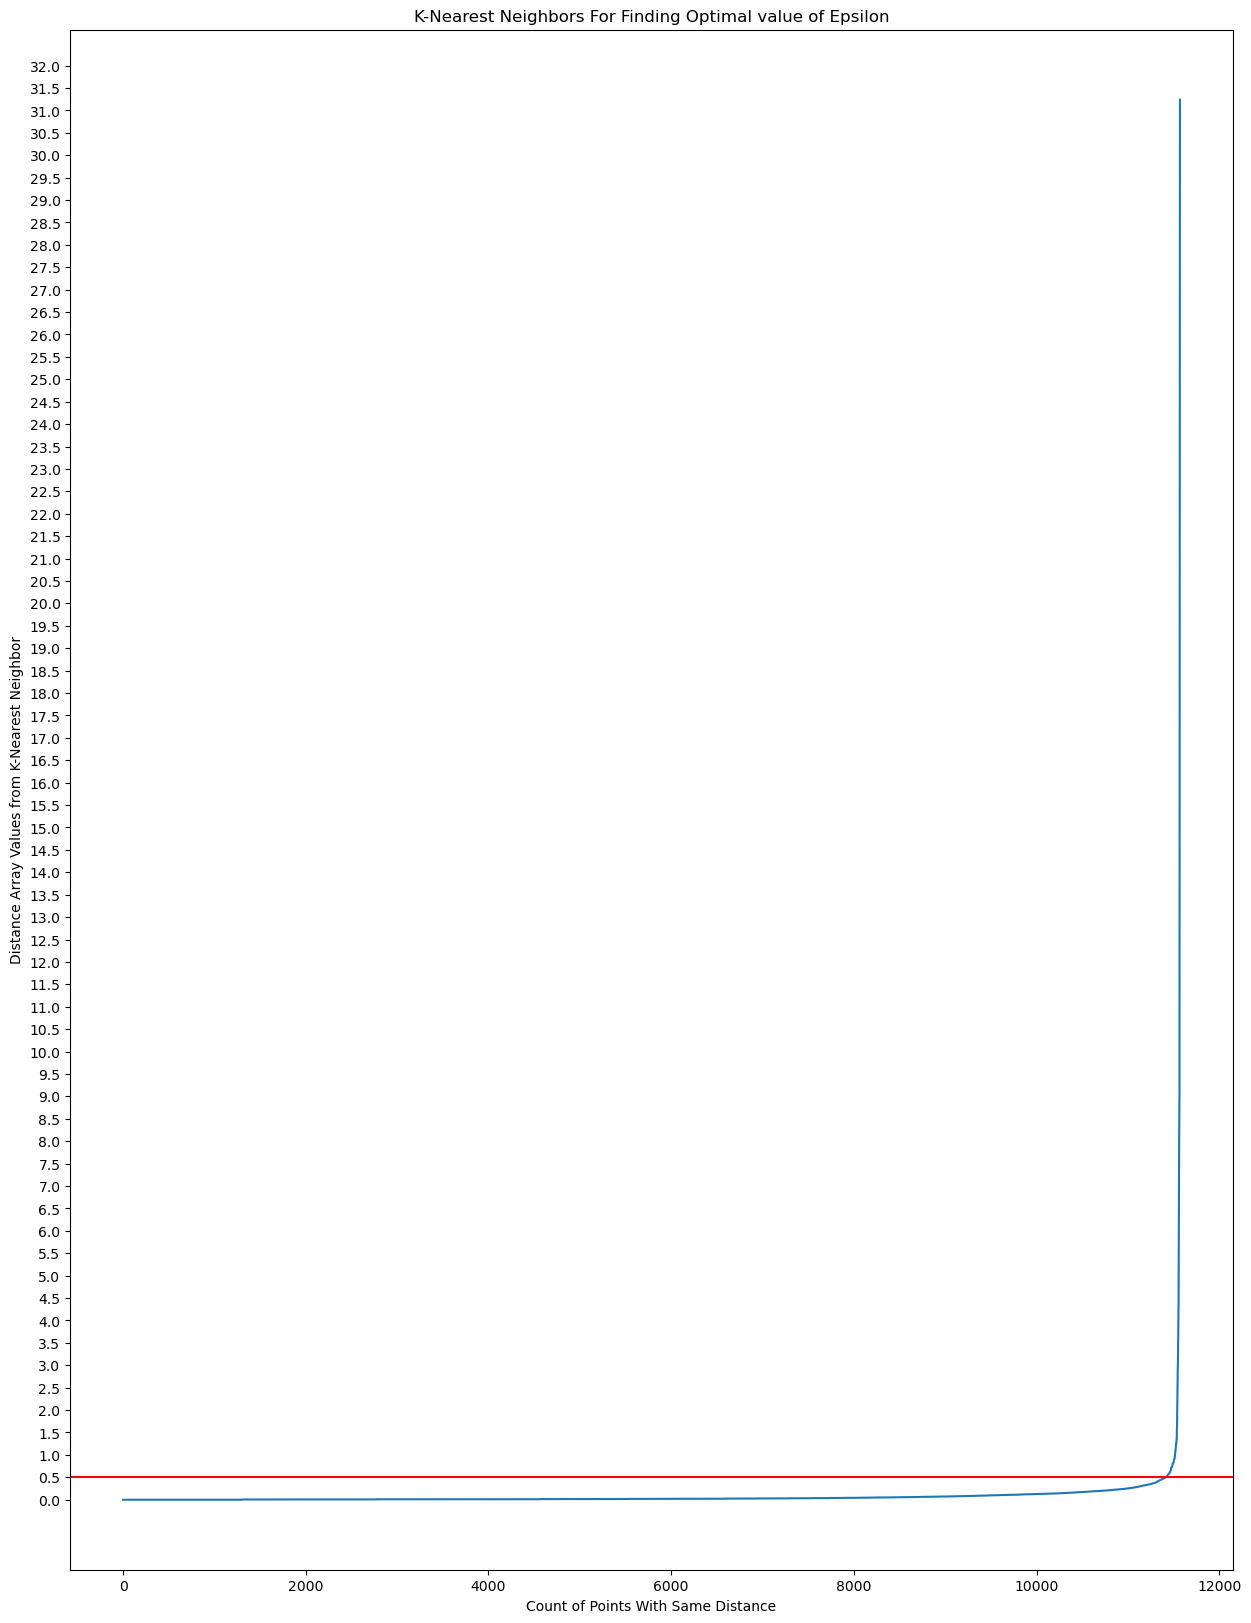

In [38]:
plt.figure(figsize=(15,20))
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.yticks(np.arange(min(distances[:,1]), max(distances[:,1])+1, 0.5))
plt.axhline(y = 0.5, color = 'r', linestyle = '-', label = 'Epsilon Value of 0.5')
plt.ylabel('Distance Array Values from K-Nearest Neighbor')
plt.xlabel('Count of Points With Same Distance')
plt.title('K-Nearest Neighbors For Finding Optimal value of Epsilon')
plt.show()

In [39]:
#DBCSAN requires the latitude and longitude in the same list
lats_longs = []
for lat, lng in zip(df_train_event_s1_spatial_data['Median_Latitude'],df_train_event_s1_spatial_data['Median_Longitude']):
    lats_longs.append([lat,lng])
    

In [40]:
#Applying dbscan algorithm to find the clusters
dbscan_algo = DBSCAN(eps= 0.5,min_samples = 4 , algorithm = 'ball_tree', metric = 'haversine', n_jobs=-1).fit(np.radians(lats_longs))

In [41]:
#Cluster labels obtained from dbscan
clusters = dbscan_algo.labels_

In [42]:
#Checking how many clusters are assigned by dbScan algo
np.unique(clusters)

array([-1,  0,  1], dtype=int64)

In [43]:
unique, counts = np.unique(clusters, return_counts=True)
print(unique)
print(counts)

[-1  0  1]
[    7 11074   490]


- Majority of points are assigned cluster label `0` as expected as we had seen in the scatter plot earlier that there were a bunch of points densly packed.
- Few points are assigned as cluster label `-1`,`1` as there are far away from the densly packed region.

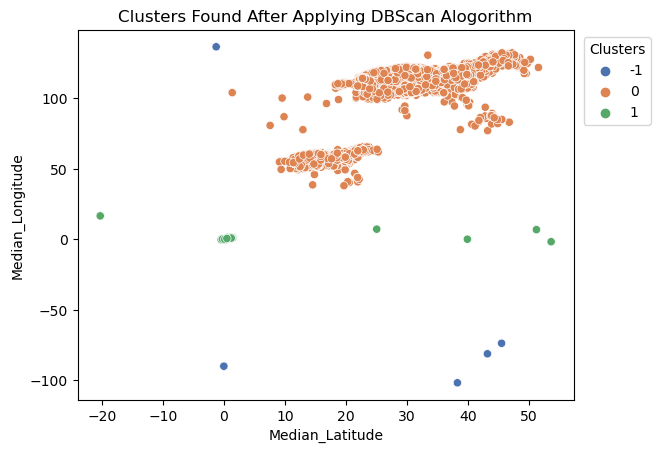

In [44]:
p = sns.scatterplot(data = df_train_event_s1_spatial_data, x = "Median_Latitude", y = "Median_Longitude", hue = clusters  , legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.title('Clusters Found After Applying DBScan Alogorithm')
plt.show()

In [45]:
#Assigning cluster label column in the dataframe from clusters got from DBSCAN
df_train_event_s1_spatial_data['Cluster_Label'] = clusters
df_train_event_s1_spatial_data.head()

,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night,Cluster_Label
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,0.0,0.0,0
2,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,0.0,0.0,0
6,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,0.0,0.0,0
18,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,0.0,0.0,0
96,1604657008397660000,F,76,Huawei,è£è€€3C,20.91,61.68,7,0.0,0.0,0.0,0.0,0


In [46]:
df_train_event_s1_spatial_data[['device_id','Cluster_Label']]

,device_id,Cluster_Label
0,-7548291590301750000,0
2,7442042493953950000,0
6,-7430262216439700000,0
18,5263633571423510000,0
96,1604657008397660000,0
...,...,...
39402823,6090808966499950000,0
39995367,-1233555371185240000,0
40187762,7454095666388370000,0
40228880,-8309150638608480000,0


In [47]:
df = df_train_event_s1_final.merge(df_train_event_s1_spatial_data[['device_id','Cluster_Label']],on ='device_id',how = 'left')
df.shape

(23182, 13)

In [48]:
#Merging the cluster label got from DBSCAN with the train_event_data
df_train_event_s1_final = df_train_event_s1_final.merge(df_train_event_s1_spatial_data[['device_id','Cluster_Label']],on ='device_id',how = 'left')
df_train_event_s1_final.shape

(23182, 13)

In [49]:
df_train_event_s1_final.head()

,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night,Cluster_Label
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,0.0,0.0,0.0
1,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,0.0,0.0,0.0
2,-800490591774117000,F,33,Huawei,hu1 Plus,0.00,0.00,1,0.0,0.0,0.0,0.0,NaN
3,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,0.0,0.0,0.0
4,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,0.0,0.0,0.0


In [50]:
df_train_event_s1_final['Cluster_Label'].value_counts()

 0.0    11074
 1.0      490
-1.0        7
Name: Cluster_Label, dtype: int64

In [51]:
#Checking if any missing values there
(df_train_event_s1_final.isna().sum()/df_train_event_s1_final.shape[0])*100 

device_id                          0.000000
gender                             0.000000
age                                0.000000
phone_brand                        0.000000
device_model                       0.000000
Median_Latitude                    0.000000
Median_Longitude                   0.000000
Number_of_Events                   0.000000
Latitude_Diff_Morning_Evening      0.000000
Longitude_Diff_Morning_Evening     0.000000
Latitude_Diff_Morning_Night        0.000000
Longitude_Diff_Morning_Night       0.000000
Cluster_Label                     50.086274
dtype: float64

In [52]:
df_train_event_s1_final[df_train_event_s1_final['Cluster_Label'].isna()]

,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night,Cluster_Label
2,-800490591774117000,F,33,Huawei,hu1 Plus,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN
5,-5552080107772750000,F,41,Huawei,Mate 7,0.0,0.0,4,0.0,0.0,0.0,0.0,NaN
6,-3441149835823130000,M,30,Huawei,è£è€€ç•…çŽ©5X,0.0,0.0,10,0.0,0.0,0.0,0.0,NaN
7,4823428704448060000,M,47,Huawei,hu1 Plus,0.0,0.0,9,0.0,0.0,0.0,0.0,NaN
11,3164462712781370000,M,33,Huawei,è£è€€ç•…çŽ©5X,0.0,0.0,2,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23177,4305425213813270000,M,20,vivo,X5Pro,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN
23178,4640046832651870000,M,47,Xiaomi,xnote3,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN
23179,231216193409511000,F,26,vivo,X6 Plus,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN
23180,-2447430485532450000,M,29,Xiaomi,xnote2,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN


- We have latitude and longitude Cluster label as `NaN` in cases where latitude and longitude both are 0.These type of data explicitly was not taken for DBSCAN clustering as for these data points the location data was not present.
- Hence we would assign a cluster label as `100` to mark these points

In [53]:
df_train_event_s1_final['Cluster_Label'].fillna(100, inplace = True)
print(df_train_event_s1_final.shape)
df_train_event_s1_final.head()

(23182, 13)


,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,Latitude_Diff_Morning_Night,Longitude_Diff_Morning_Night,Cluster_Label
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,0.0,0.0,0.0
1,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,0.0,0.0,0.0
2,-800490591774117000,F,33,Huawei,hu1 Plus,0.00,0.00,1,0.0,0.0,0.0,0.0,100.0
3,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,0.0,0.0,0.0
4,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,0.0,0.0,0.0


In [54]:
df_train_event_s1.head()

,device_id,phone_brand,device_model,gender,age,event_id,datetimestamp,latitude,longitude,Day,Hour,app_id,is_installed,is_active,Main_Category
0,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,3.433290e+18,1,1,Other
1,-7548291590301750000,Huawei,è£è€€3C,M,33,1141870,2016-05-01 10:08:16,33.98,116.79,Sunday,10,3.433290e+18,1,1,Property Industry
2,7442042493953950000,Huawei,hu1 plus,M,26,2591882,2016-05-01 18:17:43,39.43,116.98,Sunday,18,3.433290e+18,1,1,Other
3,7442042493953950000,Huawei,hu1 plus,M,26,2591882,2016-05-01 18:17:43,39.43,116.98,Sunday,18,3.433290e+18,1,1,Property Industry
4,-800490591774117000,Huawei,hu1 Plus,F,33,1455673,2016-05-01 16:45:07,0.00,0.00,Sunday,16,3.433290e+18,1,1,Other


### Feature Engineering: App Categories Used Per Device

- As seen earlier a single device can have multiple apps with various categories.
- In order to incorporate this information in our dataset we would be creating columns from the Main categories.
- Device IDs which have any apps used in main category will have the value as 1.
- For eg if device id 1 has apps used in Finance then column Finance_Apps_Used as value 1 and if no apps used in Finance then 0.

In [56]:
#Getting what devices have which type of app categories used.
grouped_data = df_train_event_s1.groupby(['device_id','Main_Category']).size().to_dict()
categories_used_per_device = {}
for key in grouped_data.keys():
    if key[0] in categories_used_per_device:
        categories_used_per_device[key[0]].append(key[1])
    else:
        categories_used_per_device[key[0]] = [key[1]]

In [57]:
categories_used_per_device

{-9222956879900150000: ['Finance', 'Media', 'Other', 'Property Industry'],
 -9221026417907250000: ['Finance',
  'Health and fitness',
  'Media',
  'Other',
  'Property Industry',
  'Shopping',
  'Travel'],
 -9220830859283100000: ['Comics and animation',
  'Other',
  'Property Industry',
  'Science and Technology'],
 -9220061629197650000: ['Media', 'Other', 'Property Industry'],
 -9218960997324660000: ['Finance',
  'Home and furniture',
  'Media',
  'Other',
  'Property Industry',
  'Science and Technology'],
 -9218769147970100000: ['Finance', 'Other', 'Property Industry'],
 -9217193238265890000: ['Media', 'Other', 'Property Industry', 'Travel'],
 -9216200545381120000: ['Media', 'Other', 'Property Industry'],
 -9215964883962790000: ['Media', 'Other', 'Property Industry'],
 -9215766592714660000: ['Maternal and child',
  'Media',
  'Other',
  'Property Industry'],
 -9215352913819630000: ['Finance', 'Media', 'Other', 'Property Industry'],
 -9214243372173200000: ['Finance',
  'Health and fi

In [58]:
#Creating a categories map which will be later used for indexing purposes
categories_map = {'Other':0}
index = 1
for category in categories_grouped.keys():
    categories_map[category] = index
    index += 1
categories_map

{'Other': 0,
 'Finance': 1,
 'Science and Technology': 2,
 'Shopping': 3,
 'Property Industry': 4,
 'Gaming': 5,
 'Maternal and child': 6,
 'Travel': 7,
 'Sports': 8,
 'Comics and animation': 9,
 'Education': 10,
 'Media': 11,
 'Home and furniture': 12,
 'Health and fitness': 13}

In [59]:
main_categories_used_per_device ={}
for key,categories in categories_used_per_device.items():
    main_categories_used_per_device[key] = [0]*(len(categories_grouped.keys())+1)
    for category in categories:
        main_categories_used_per_device[key][categories_map[category]] = 1


In [60]:
main_categories_used_per_device

{-9222956879900150000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9221026417907250000: [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1],
 -9220830859283100000: [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 -9220061629197650000: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9218960997324660000: [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 -9218769147970100000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 -9217193238265890000: [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 -9216200545381120000: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9215964883962790000: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9215766592714660000: [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 -9215352913819630000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9214243372173200000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 -9213722931755350000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9212424538588390000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 -9212412905070440000: [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,

In [61]:
#Assigning the apps used category for each device id to the dataframe
def map_device_ids(device_id, category):
    if main_categories_used_per_device.get(device_id):
        return main_categories_used_per_device[device_id][categories_map[category]]
    else:
        return 0
    
for category in categories_map.keys():
    category_clean = category.replace(' ','_')
    df_train_event_s1_final[f'{category_clean}_Apps_Used'] = df_train_event_s1_final['device_id'].apply(lambda val:map_device_ids(val, category))

print(df_train_event_s1_final.shape)
df_train_event_s1_final.head()

(23182, 27)


,device_id,gender,age,phone_brand,device_model,Median_Latitude,Median_Longitude,Number_of_Events,Latitude_Diff_Morning_Evening,Longitude_Diff_Morning_Evening,...,Property_Industry_Apps_Used,Gaming_Apps_Used,Maternal_and_child_Apps_Used,Travel_Apps_Used,Sports_Apps_Used,Comics_and_animation_Apps_Used,Education_Apps_Used,Media_Apps_Used,Home_and_furniture_Apps_Used,Health_and_fitness_Apps_Used
0,-7548291590301750000,M,33,Huawei,è£è€€3C,33.98,116.79,1,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
1,7442042493953950000,M,26,Huawei,hu1 plus,39.43,116.98,1,0.0,0.0,...,1,0,0,0,0,0,0,1,0,1
2,-800490591774117000,F,33,Huawei,hu1 Plus,0.00,0.00,1,0.0,0.0,...,1,0,0,0,0,0,0,1,0,1
3,-7430262216439700000,M,42,Huawei,Mate 7,22.66,114.33,6,0.0,0.0,...,1,0,0,0,0,1,0,1,1,1
4,5263633571423510000,M,27,Huawei,hu1 Plus,30.39,114.42,17,0.0,0.0,...,1,0,0,0,0,0,0,1,0,1


In [62]:
df_train_event_s1_final.columns

Index(['device_id', 'gender', 'age', 'phone_brand', 'device_model',
       'Median_Latitude', 'Median_Longitude', 'Number_of_Events',
       'Latitude_Diff_Morning_Evening', 'Longitude_Diff_Morning_Evening',
       'Latitude_Diff_Morning_Night', 'Longitude_Diff_Morning_Night',
       'Cluster_Label', 'Other_Apps_Used', 'Finance_Apps_Used',
       'Science_and_Technology_Apps_Used', 'Shopping_Apps_Used',
       'Property_Industry_Apps_Used', 'Gaming_Apps_Used',
       'Maternal_and_child_Apps_Used', 'Travel_Apps_Used', 'Sports_Apps_Used',
       'Comics_and_animation_Apps_Used', 'Education_Apps_Used',
       'Media_Apps_Used', 'Home_and_furniture_Apps_Used',
       'Health_and_fitness_Apps_Used'],
      dtype='object')

In [63]:
#Saving train_event_data_after feature engineering
path = 'E:\\Shobhit\\MSDS\\Capstone\\Y1_Capstone\\data\\final_data'
df_train_event_s1_final.to_csv(f'{path}\\scenario1_data.csv',index=False)
df_train_event_s2.to_csv(f'{path}\\scenario2_data.csv',index=False)